# Tone slicing

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
import cupy as cp

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [5]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [14]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

## Inputs & Data

Explanation of each input and where it comes from.

In [15]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [16]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [17]:
BAND_TO_FREQ = {"theta": (6,11), "beta": (20,31), "gamma": (30,51)}

In [18]:
LFP_TRACES_DF = pd.read_pickle("/blue/npadillacoreano/ryoi360/projects/reward_competition_extention/results/2024_01_30_rce_2nd_cohort/proc/rce2_spectral_granger.pkl")

In [19]:
LFP_TRACES_DF.head()

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,LH_vHPC_granger_all_frequencies_all_windows,vHPC_LH_granger_all_frequencies_all_windows,MD_mPFC_granger_all_frequencies_all_windows,mPFC_MD_granger_all_frequencies_all_windows,MD_vHPC_granger_all_frequencies_all_windows,vHPC_MD_granger_all_frequencies_all_windows,mPFC_vHPC_granger_all_frequencies_all_windows,vHPC_mPFC_granger_all_frequencies_all_windows,granger_timestamps,granger_calculation_frequencies
0,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,...,"[[1.216, 0.633, 0.282, 0.613, 0.636, 1.501, 0....","[[0.39, 0.2312, 0.02298, 0.1543, 0.315, 0.7856...","[[1.783, 1.615, 1.699, 0.9365, 1.126, 1.648, 0...","[[1.663, 0.849, 1.167, 0.758, 0.328, 0.7144, 1...","[[2.055, 0.452, 0.3164, 0.5933, 0.8477, 0.6006...","[[0.1825, 0.1715, 0.01872, 0.096, 0.2727, 0.36...","[[0.3892, 0.2598, 0.1339, 0.1823, 0.2996, nan,...","[[0.0007057, 0.2181, 0.2163, 0.5986, 0.6187, 0...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,...,"[[2.848, 1.116, 0.682, 0.198, 0.154, 0.127, 0....","[[1.97, 1.198, 0.10645, 0.2512, 0.3628, 0.595,...","[[0.09326, 0.08734, 0.136, 0.0357, 0.1394, 0.2...","[[1.11, 0.2117, 0.3718, 0.1334, 0.174, 0.7544,...","[[1.734, 1.35, 0.8564, 0.2327, 0.08453, 0.0556...","[[1.0205, 0.565, 0.1328, 0.256, 0.311, 0.3535,...","[[1.432, 2.252, 0.566, 0.302, 0.1381, 0.6523, ...","[[nan, 0.8276, 1.56, 0.672, 0.3506, 0.01371, 0...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[[0.326, 0.1089, 0.624, 0.2566, 0.06903, 0.112...","[[0.4377, 0.1589, 0.2129, 0.3435, 0.5723, 1.25...","[[0.01956, 0.05756, 0.04272, 0.108, 0.4011, 1....","[[0.1444, 0.5464, 0.3662, 0.3176, 0.2191, 0.08...","[[0.8516, 0.1353, 0.897, 0.2006, 0.02, 0.1517,...","[[0.273, 0.1354, 0.1842, 0.1063, 0.9165, 0.894...","[[0.1587, 0.256, 0.2253, 0.1144, 0.04657, 0.24...","[[0.386, 0.0818, 0.07935, 0.03128, 0.2976, 1.4...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[[0.05106, 0.03592, 0.804, 1.848, 0.3523, 1.55...","[[0.5166, nan, 0.236, 0.238, 0.282, 1.07, 0.03...","[[2.38, nan, 0.556, 0.719, 0.4656, 1.49, 1.627...","[[0.828, 0.4062, 0.2362, 0.0009437, 0.02545, 0...","[[0.

## Getting the slice of each tone

In [21]:
LFP_TRACES_DF.columns

Index(['cohort', 'session_dir', 'original_file', 'tone_frames',
       'box_1_port_entry_frames', 'box_2_port_entry_frames', 'video_name',
       'session_path', 'recording', 'current_subject', 'subject',
       'all_subjects', 'first_timestamp', 'last_timestamp', 'video_timestamps',
       'tone_timestamps', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', 'lfp_timestamps', 'mPFC_lfp_trace',
       'MD_lfp_trace', 'LH_lfp_trace', 'BLA_lfp_trace', 'vHPC_lfp_trace',
       'mPFC_power_all_frequencies_all_windows',
       'MD_power_all_frequencies_all_windows',
       'LH_power_all_frequencies_all_windows',
       'BLA_power_all_frequencies_all_windows',
       'vHPC_power_all_frequencies_all_windows', 'power_timestamps',
       'power_calculation_frequencies',
       'BLA_LH_coherence_all_frequencies_all_windows',
       'BLA_MD_coherence_all_frequencies_all_windows',
       'BLA_mPFC_coherence_all_frequencies_all_windows',
       'BLA_vHPC_coherence_all_frequencies_

In [25]:
power_columns = [col for col in LFP_TRACES_DF.columns if "power_all_frequencies_all_windows" in col]

In [26]:
power_columns

['mPFC_power_all_frequencies_all_windows',
 'MD_power_all_frequencies_all_windows',
 'LH_power_all_frequencies_all_windows',
 'BLA_power_all_frequencies_all_windows',
 'vHPC_power_all_frequencies_all_windows']

In [38]:
for col in power_columns:
    brain_region = col.split("_")[0]
    LFP_TRACES_DF["{}_power_all_frequencies_all_tones".format(brain_region)] = LFP_TRACES_DF.apply(lambda x: [x[col][np.logical_and((x["power_timestamps"] >= start), (x["power_timestamps"] <= end))] for (start, end) in x["tone_timestamps"]], axis=1)

In [43]:
coherence_columns = [col for col in LFP_TRACES_DF.columns if "coherence_all_frequencies_all_windows" in col]

In [45]:
coherence_columns

['BLA_LH_coherence_all_frequencies_all_windows',
 'BLA_MD_coherence_all_frequencies_all_windows',
 'BLA_mPFC_coherence_all_frequencies_all_windows',
 'BLA_vHPC_coherence_all_frequencies_all_windows',
 'LH_MD_coherence_all_frequencies_all_windows',
 'LH_mPFC_coherence_all_frequencies_all_windows',
 'LH_vHPC_coherence_all_frequencies_all_windows',
 'MD_mPFC_coherence_all_frequencies_all_windows',
 'MD_vHPC_coherence_all_frequencies_all_windows',
 'mPFC_vHPC_coherence_all_frequencies_all_windows']

In [56]:
for col in coherence_columns:
    brain_region = "_".join(col.split("_")[:2])
    print(brain_region)
    LFP_TRACES_DF["{}_coherence_all_frequencies_all_tones".format(brain_region)] = LFP_TRACES_DF.apply(lambda x: [x[col][np.logical_and((x["coherence_timestamps"] >= start), (x["coherence_timestamps"] <= end))] for (start, end) in x["tone_timestamps"]], axis=1)

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [57]:
granger_columns = [col for col in LFP_TRACES_DF.columns if "granger_all_frequencies_all_windows" in col]

In [58]:
granger_columns

['BLA_LH_granger_all_frequencies_all_windows',
 'LH_BLA_granger_all_frequencies_all_windows',
 'BLA_MD_granger_all_frequencies_all_windows',
 'MD_BLA_granger_all_frequencies_all_windows',
 'BLA_mPFC_granger_all_frequencies_all_windows',
 'mPFC_BLA_granger_all_frequencies_all_windows',
 'BLA_vHPC_granger_all_frequencies_all_windows',
 'vHPC_BLA_granger_all_frequencies_all_windows',
 'LH_MD_granger_all_frequencies_all_windows',
 'MD_LH_granger_all_frequencies_all_windows',
 'LH_mPFC_granger_all_frequencies_all_windows',
 'mPFC_LH_granger_all_frequencies_all_windows',
 'LH_vHPC_granger_all_frequencies_all_windows',
 'vHPC_LH_granger_all_frequencies_all_windows',
 'MD_mPFC_granger_all_frequencies_all_windows',
 'mPFC_MD_granger_all_frequencies_all_windows',
 'MD_vHPC_granger_all_frequencies_all_windows',
 'vHPC_MD_granger_all_frequencies_all_windows',
 'mPFC_vHPC_granger_all_frequencies_all_windows',
 'vHPC_mPFC_granger_all_frequencies_all_windows']

In [59]:
for col in granger_columns:
    brain_region = "_".join(col.split("_")[:2])
    print(brain_region)
    LFP_TRACES_DF["{}_granger_all_frequencies_all_tones".format(brain_region)] = LFP_TRACES_DF.apply(lambda x: [x[col][np.logical_and((x["granger_timestamps"] >= start), (x["granger_timestamps"] <= end))] for (start, end) in x["tone_timestamps"]], axis=1)

BLA_LH
LH_BLA
BLA_MD
MD_BLA
BLA_mPFC
mPFC_BLA
BLA_vHPC
vHPC_BLA
LH_MD
MD_LH
LH_mPFC
mPFC_LH
LH_vHPC
vHPC_LH
MD_mPFC
mPFC_MD
MD_vHPC
vHPC_MD
mPFC_vHPC
vHPC_mPFC


In [60]:
LFP_TRACES_DF.head()

,cohort,session_dir,original_file,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,...,LH_mPFC_granger_all_frequencies_all_tones,mPFC_LH_granger_all_frequencies_all_tones,LH_vHPC_granger_all_frequencies_all_tones,vHPC_LH_granger_all_frequencies_all_tones,MD_mPFC_granger_all_frequencies_all_tones,mPFC_MD_granger_all_frequencies_all_tones,MD_vHPC_granger_all_frequencies_all_tones,vHPC_MD_granger_all_frequencies_all_tones,mPFC_vHPC_granger_all_frequencies_all_tones,vHPC_mPFC_granger_all_frequencies_all_tones
0,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,...,"[[[0.02559, 0.217, 0.2864, 0.1173, 0.013275, 0...","[[[0.7275, 0.395, 1.2, 0.419, 0.06555, 0.2083,...","[[[0.3564, 0.006203, 0.04623, 0.0738, 0.02225,...","[[[0.02269, 0.1727, 0.1677, 0.05524, 0.1885, 0...","[[[0.000793, 0.00719, 0.0329, 0.10266, 0.1116,...","[[[0.1024, 0.5317, 1.691, 0.333, 0.3748, 0.160...","[[[0.473, 0.12024, 0.3696, 0.1598, 0.08344, 0....","[[[1.354, 2.066, 0.2783, 0.543, 0.04102, 0.064...","[[[0.2996, 0.4377, 0.9536, 0.2041, 0.1239, 0.3...","[[[nan, 0.6577, 1.055, 0.669, 0.5767, 0.2238, ..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[980, 1180], [3376, 3575], [5672, 5871], [746...","[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,...,"[[[0.892, 0.5625, 0.0394, 0.00834, 0.1284, 0.0...","[[[3.06, 0.5107, 0.783, 0.755, 0.6074, 0.4492,...","[[[0.0933, 0.0499, 0.0913, 0.3296, 0.2773, 0.2...","[[[0.0952, 0.693, 0.617, 0.656, 0.01146, 0.193...","[[[0.7627, 0.4146, 0.1236, 0.003307, 0.0941, 8...","[[[2.906, 0.1997, 0.653, 0.3142, 0.3665, 0.467...","[[[0.2329, 0.2856, 0.1501, 0.5786, 0.3108, 0.3...","[[[0.00647, 0.7847, 0.2278, 0.6094, 0.09735, 0...","[[[1.928, 0.3743, 0.2155, 0.2147, 0.58, 0.4675...","[[[nan, 0.715, 0.04117, 0.02257, 0.3499, 0.215..."
2,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,...,"[[[nan, 0.0532, 0.536, 0.02722, 0.2935, 0.0189...","[[[0.1527, 0.1676, 0.7847, 0.0815, 0.2507, 0.1...","[[[0.05975, 0.08344, 0.6553, 0.4275, 1.307, 0....","[[[0.528, 0.1727, 0.05893, 0.05194, 0.0725, 0....","[[[nan, 0.0742, 0.512, 0.0797, 0.3408, 0.1895,...","[[[0.01932, 0.1401, 0.5957, 0.07996, 0.11487, ...","[[[0.10864, 0.5127, 0.7993, 0.913, 1.044, 0.74...","[[[0.791, 0.737, 0.02872, 0.1674, 0.1808, 0.08...","[[[1.057, 0.1718, 0.5137, 0.1847, 0.6343, 0.03...","[[[0.001826, 0.05145, 0.002533, 0.01627, 0.067..."
3,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[1125, 1324], [3519, 3720], [5815, 6014], [76...","[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,...,"[[[0.706, 0.11206, 0.5894, 0.411, 0.924, 1.325...","[[[0.5166, 0.6353, 0.417, 0.5444, 0.1853, 0.40...","[[[0.06274, 0.0958, 0.2297, 0.672, 0.1718, 0.5...","[[[0.5063, 0.253, 0.0963, 0.1469, 0.023

In [74]:
COL_TO_KEEP = ['cohort', 'session_dir', 'original_file',
       'box_1_port_entry_frames', 'box_2_port_entry_frames', 'video_name',
       'session_path', 'recording', 'current_subject', 'subject',
       'all_subjects', 'first_timestamp', 'last_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps']

,cohort,session_dir,original_file,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,all_subjects,first_timestamp,last_timestamp,box_1_port_entry_timestamps,box_2_port_entry_timestamps
0,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
1,2,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,"[[490, 514], [518, 558], [558, 637], [638, 640...","[[33021, 33027], [33502, 33503], [33504, 33506...",20230612_101430_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.4,1.4,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [..."
2,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.1,1.1,"[1.1, 1.2]",7977066,76318450,"[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."
3,2,20230612_112630_standard_comp_to_training_D1_s...,20230612_112630_standard_comp_to_training_D1_s...,"[[192, 248], [389, 405], [916, 929], [929, 948...","[[33019, 33020], [33246, 33251], [33253, 33255...",20230612_112630_standard_comp_to_training_D1_s...,/scratch/back_up/reward_competition_extention/...,20230612_112630_standard_comp_to_training_D1_s...,1.2,1.2,"[1.1, 1.2]",7977066,76318450,"[[192745, 249350], [389747, 407142], [917544, ...","[[33037711, 33038706], [33264908, 33270313], [..."
4,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.1,1.1,"[1.1, 1.4]",7454593,75876357,"[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [..."
5,2,20230613_105657_standard_comp_to_training_D2_s...,20230613_105657_standard_comp_to_training_D2_s...,"[[49, 67], [70, 79], [360, 366], [460, 469], [...","[[33601, 33798], [34108, 34165], [34166, 34179...",20230613_105657_standard_comp_to_training_D2_s...,/scratch/back_up/reward_competition_extention/...,20230613_105657_standard_comp_to_training_D2_s...,1.4,1.4,"[1.1, 1.4]",7454593,75876357,"[[49358, 67558], [70155, 79355], [360955, 3671...","[[33624333, 33822933], [34132932, 34190535], [..."
6,2,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,"[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...",20230614_114041_standard_comp_to_training_D3_s...,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,1.1,1.1,"[1.1, 1.2]",34373723,102449020,"[[22157, 27562], [111755, 127157], [278955, 32...","[[33048338, 33059738], [33066538, 33067341], [..."
7,2,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,"[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...",20230614_114041_standard_comp_to_training_D3_s...,

In [64]:
tone_columns = [col for col in LFP_TRACES_DF.columns if "tone" in col]

In [65]:
EXPLODED_LFP_TRACES_DF = pd.concat([LFP_TRACES_DF[col].explode() for col in tone_columns], axis=1)


In [77]:
MERGED_LFP_TRACES_DF = pd.merge(EXPLODED_LFP_TRACES_DF, LFP_TRACES_DF[COL_TO_KEEP], how="inner", left_index=True, right_index=True)

In [78]:
MERGED_LFP_TRACES_DF.columns

Index(['tone_frames', 'tone_timestamps',
       'mPFC_power_all_frequencies_all_tones',
       'MD_power_all_frequencies_all_tones',
       'LH_power_all_frequencies_all_tones',
       'BLA_power_all_frequencies_all_tones',
       'vHPC_power_all_frequencies_all_tones',
       'BLA_LH_coherence_all_frequencies_all_tones',
       'BLA_MD_coherence_all_frequencies_all_tones',
       'BLA_mPFC_coherence_all_frequencies_all_tones',
       'BLA_vHPC_coherence_all_frequencies_all_tones',
       'LH_MD_coherence_all_frequencies_all_tones',
       'LH_mPFC_coherence_all_frequencies_all_tones',
       'LH_vHPC_coherence_all_frequencies_all_tones',
       'MD_mPFC_coherence_all_frequencies_all_tones',
       'MD_vHPC_coherence_all_frequencies_all_tones',
       'mPFC_vHPC_coherence_all_frequencies_all_tones',
       'BLA_LH_granger_all_frequencies_all_tones',
       'LH_BLA_granger_all_frequencies_all_tones',
       'BLA_MD_granger_all_frequencies_all_tones',
       'MD_BLA_granger_all_frequenci

In [82]:
MERGED_LFP_TRACES_DF["time_stamp_index"] = MERGED_LFP_TRACES_DF["tone_timestamps"].apply(lambda x: x[0])

In [83]:
MERGED_LFP_TRACES_DF

,tone_frames,tone_timestamps,mPFC_power_all_frequencies_all_tones,MD_power_all_frequencies_all_tones,LH_power_all_frequencies_all_tones,BLA_power_all_frequencies_all_tones,vHPC_power_all_frequencies_all_tones,BLA_LH_coherence_all_frequencies_all_tones,BLA_MD_coherence_all_frequencies_all_tones,BLA_mPFC_coherence_all_frequencies_all_tones,...,session_path,recording,current_subject,subject,all_subjects,first_timestamp,last_timestamp,box_1_port_entry_timestamps,box_2_port_entry_timestamps,time_stamp_index
0,"[980, 1180]","[982229, 1182226]","[[0.03735, 0.02225, 0.02402, 0.0362, 0.03998, ...","[[0.4868, 0.5845, 0.594, 0.1986, 0.04138, 0.01...","[[0.013916, 0.01822, 0.01921, 0.0194, 0.01383,...","[[0.008415, 0.0122, 0.01417, 0.01495, 0.01073,...","[[0.001052, 0.01031, 0.02203, 0.02713, 0.02509...","[[0.3523, 0.1758, 0.1431, 0.2976, 0.7993, 0.85...","[[0.9194, 0.851, 0.5703, 0.682, 0.5513, 0.298,...","[[0.779, 0.7515, 0.06134, 0.2617, 0.7563, 0.85...",...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",982229
0,"[3376, 3575]","[3382227, 3582224]","[[0.3538, 0.3096, 0.3787, 0.2727, 0.1991, 0.17...","[[0.03137, 0.01913, 0.04147, 0.04736, 0.05664,...","[[0.010414, 0.008224, 0.02959, 0.03525, 0.0552...","[[0.01521, 0.01127, 0.01417, 0.01839, 0.08905,...","[[1.356, 1.254, 1.23, 1.016, 0.709, 0.621, 0.5...","[[0.9272, 0.656, 0.5654, 0.5977, 0.7363, 0.758...","[[0.971, 0.946, 0.6934, 0.6626, 0.624, 0.5405,...","[[0.712, 0.9507, 0.4402, 0.2666, 0.3286, 0.535...",...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",3382227
0,"[5672, 5871]","[5682225, 5882222]","[[0.005627, 0.0082, 0.02856, 0.02502, 0.02675,...","[[0.002995, 0.006123, 0.01249, 0.01134, 0.0106...","[[0.00457, 0.01611, 0.02945, 0.02557, 0.01985,...","[[0.001195, 0.006264, 0.01048, 0.013275, 0.015...","[[0.007504, 0.01108, 0.01573, 0.01001, 0.00817...","[[0.8438, 0.9785, 0.9688, 0.8286, 0.7593, 0.73...","[[0.4626, 0.8745, 0.8203, 0.6245, 0.5596, 0.59...","[[0.92, 0.921, 0.899, 0.74, 0.7314, 0.7783, 0....",...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",5682225
0,"[7468, 7668]","[7482224, 7682221]","[[0.005745, 0.02194, 0.05325, 0.04877, 0.03702...","[[0.003006, 0.00328, 0.004528, 0.006573, 0.002...","[[0.003529, 0.005146, 0.00888, 0.01143, 0.0079...","[[0.004852, 0.00552, 0.006077, 0.00874, 0.0052...","[[0.02538, 0.02655, 0.04022, 0.03918, 0.02568,...","[[0.902, 0.953, 0.815, 0.8394, 0.8403, 0.899, ...","[[0.648, 0.9155, 0.515, 0.7007, 0.6255, 0.8145...","[[0.000729, 0.266, 0.3923, 0.4963, 0.6743, 0.6...",...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33090003], [33565003, 33567000], [...",7482224
0,"[8566, 8765]","[8582220, 8782223]","[[0.02032, 0.01335, 0.06146, 0.0738, 0.06052, ...","[[0.007442, 0.0293, 0.0334, 0.04352, 0.02269, ...","[[0.00676, 0.02718, 0.03287, 0.0481, 0.03308, ...","[[0.000627, 0.0271, 0.04706, 0.05704, 0.0778, ...","[[0.0007944, 0.02773, 0.0326, 0.03049, 0.01246...","[[0.9985, 0.7417, 0.64, 0.7617, 0.6187, 0.0867...","[[0.9995, 0.706, 0.554, 0.708, 0.671, 0.11505,...","[[0.3945, 0.2184, 0.55, 0.7046, 0.674, 0.4905,...",...,/scratch/back_up/reward_competition_extention/...,20230612_101430_standard_comp_to_training_D1_s...,1.3,1.3,"[1.3, 1.4]",8798886,77093151,"[[491029, 515227], [519426, 558629], [559427, ...","[[33082200, 33

In [81]:
MERGED_LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_tone_sliced.pkl")

# Merging with the trial labels

In [149]:
TRIAL_LABELS_DF = pd.read_excel("./rce_per_trial_labeling.xlsx")

In [150]:
TRIAL_LABELS_DF = TRIAL_LABELS_DF[['video_file', 'time_stamp_index', 'condition ', 'competition_closeness',
       'notes', 'experiment']].copy()

In [151]:
TRIAL_LABELS_DF = TRIAL_LABELS_DF.rename(columns={col: col.strip(" ") for col in TRIAL_LABELS_DF.columns})

In [152]:
MERGED_LFP_TRACES_DF.columns

Index(['tone_frames', 'tone_timestamps',
       'mPFC_power_all_frequencies_all_tones',
       'MD_power_all_frequencies_all_tones',
       'LH_power_all_frequencies_all_tones',
       'BLA_power_all_frequencies_all_tones',
       'vHPC_power_all_frequencies_all_tones',
       'BLA_LH_coherence_all_frequencies_all_tones',
       'BLA_MD_coherence_all_frequencies_all_tones',
       'BLA_mPFC_coherence_all_frequencies_all_tones',
       'BLA_vHPC_coherence_all_frequencies_all_tones',
       'LH_MD_coherence_all_frequencies_all_tones',
       'LH_mPFC_coherence_all_frequencies_all_tones',
       'LH_vHPC_coherence_all_frequencies_all_tones',
       'MD_mPFC_coherence_all_frequencies_all_tones',
       'MD_vHPC_coherence_all_frequencies_all_tones',
       'mPFC_vHPC_coherence_all_frequencies_all_tones',
       'BLA_LH_granger_all_frequencies_all_tones',
       'LH_BLA_granger_all_frequencies_all_tones',
       'BLA_MD_granger_all_frequencies_all_tones',
       'MD_BLA_granger_all_frequenci

In [153]:
MERGED_LFP_TRACES_DF["video_name"].iloc[0]

'20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2.videoTimeStamps.cameraHWSync'

In [154]:
TRIAL_LABELS_DF["video_file"].iloc[100]

'20221202_134600_omission_and_competition_subject_6_1_and_6_2.1.videoTimeStamps.cameraHWSync'

In [155]:
FINAL_LFP_TRACES_DF = pd.merge(MERGED_LFP_TRACES_DF, TRIAL_LABELS_DF, left_on=["video_name", "time_stamp_index"], right_on=["video_file", "time_stamp_index"], how="inner")

In [156]:
FINAL_LFP_TRACES_DF.columns

Index(['tone_frames', 'tone_timestamps',
       'mPFC_power_all_frequencies_all_tones',
       'MD_power_all_frequencies_all_tones',
       'LH_power_all_frequencies_all_tones',
       'BLA_power_all_frequencies_all_tones',
       'vHPC_power_all_frequencies_all_tones',
       'BLA_LH_coherence_all_frequencies_all_tones',
       'BLA_MD_coherence_all_frequencies_all_tones',
       'BLA_mPFC_coherence_all_frequencies_all_tones',
       'BLA_vHPC_coherence_all_frequencies_all_tones',
       'LH_MD_coherence_all_frequencies_all_tones',
       'LH_mPFC_coherence_all_frequencies_all_tones',
       'LH_vHPC_coherence_all_frequencies_all_tones',
       'MD_mPFC_coherence_all_frequencies_all_tones',
       'MD_vHPC_coherence_all_frequencies_all_tones',
       'mPFC_vHPC_coherence_all_frequencies_all_tones',
       'BLA_LH_granger_all_frequencies_all_tones',
       'LH_BLA_granger_all_frequencies_all_tones',
       'BLA_MD_granger_all_frequencies_all_tones',
       'MD_BLA_granger_all_frequenci

In [157]:
FINAL_LFP_TRACES_DF = FINAL_LFP_TRACES_DF.dropna(subset=["experiment", "condition"]).reset_index(drop=True)

In [158]:
FINAL_LFP_TRACES_DF["condition"].unique()

array([1.2, 'both_rewarded', 1.1, 1.4, 2.2], dtype=object)

In [159]:
FINAL_LFP_TRACES_DF["all_subjects"]

0                [1.1, 1.2]
1                [1.1, 1.2]
2                [1.1, 1.2]
3                [1.1, 1.2]
4                [1.1, 1.2]
               ...         
267    [1.2, 1.4, 2.1, 2.2]
268    [1.2, 1.4, 2.1, 2.2]
269    [1.2, 1.4, 2.1, 2.2]
270    [1.2, 1.4, 2.1, 2.2]
271    [1.2, 1.4, 2.1, 2.2]
Name: all_subjects, Length: 272, dtype: object

In [160]:
FINAL_LFP_TRACES_DF["trial_outcome"] = FINAL_LFP_TRACES_DF.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [161]:
FINAL_LFP_TRACES_DF["trial_outcome"].unique()

array(['lose', 'win', 'both_rewarded'], dtype=object)

In [182]:
FINAL_LFP_TRACES_DF["trial_label"] = FINAL_LFP_TRACES_DF.apply(lambda x: "_".join(("{}_{}".format(x["trial_outcome"], x["experiment"]).split("_")[:2])), axis=1)

In [183]:
FINAL_LFP_TRACES_DF["trial_label"].unique()

array(['lose_standard', 'win_standard', 'both_rewarded', 'lose_novel',
       'win_novel'], dtype=object)

In [185]:
FINAL_LFP_TRACES_DF.head()

,tone_frames,tone_timestamps,mPFC_power_all_frequencies_all_tones,MD_power_all_frequencies_all_tones,LH_power_all_frequencies_all_tones,BLA_power_all_frequencies_all_tones,vHPC_power_all_frequencies_all_tones,BLA_LH_coherence_all_frequencies_all_tones,BLA_MD_coherence_all_frequencies_all_tones,BLA_mPFC_coherence_all_frequencies_all_tones,...,box_1_port_entry_timestamps,box_2_port_entry_timestamps,time_stamp_index,video_file,condition,competition_closeness,notes,experiment,trial_outcome,trial_label
0,"[1129, 1328]","[1131200, 1331202]","[[0.0138, 0.0167, 0.01796, 0.01152, 0.01123, 0...","[[0.02945, 0.0214, 0.02567, 0.02292, 0.02539, ...","[[0.0253, 0.01634, 0.01633, 0.00984, 0.01269, ...","[[0.013145, 0.01462, 0.0228, 0.03537, 0.02652,...","[[0.05573, 0.0491, 0.06235, 0.05536, 0.01588, ...","[[0.9756, 0.8276, 0.803, 0.931, 0.512, 0.401, ...","[[0.9863, 0.8853, 0.875, 0.834, 0.3848, 0.2369...","[[0.994, 0.837, 0.6187, 0.6235, 0.384, 0.2172,...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",1131200,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,lose,lose_standard
1,"[1129, 1328]","[1131200, 1331202]","[[0.004276, 0.0256, 0.0421, 0.05676, 0.06396, ...","[[0.010864, 0.02293, 0.04822, 0.0631, 0.0704, ...","[[0.003767, 0.01213, 0.0324, 0.05438, 0.0631, ...","[[0.0135, 0.02692, 0.03873, 0.05573, 0.04813, ...","[[0.03403, 0.02121, 0.02156, 0.03014, 0.03955,...","[[0.2593, 0.866, 0.7036, 0.7153, 0.857, 0.967,...","[[0.1398, 0.847, 0.8374, 0.7793, 0.8467, 0.97,...","[[0.2059, 0.78, 0.791, 0.705, 0.6836, 0.7295, ...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",1131200,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,win,win_standard
2,"[3525, 3724]","[3531230, 3731233]","[[0.010864, 0.00797, 0.01267, 0.01032, 0.00752...","[[0.003769, 0.00765, 0.01425, 0.015495, 0.0107...","[[0.00691, 0.00942, 0.012276, 0.011116, 0.0094...","[[0.00294, 0.002851, 0.005985, 0.004627, 0.003...","[[0.135, 0.1455, 0.2109, 0.1934, 0.1283, 0.031...","[[0.2942, 0.504, 0.552, 0.196, 0.04318, 0.8164...","[[0.3438, 0.3784, 0.642, 0.2698, 0.0341, 0.857...","[[0.07153, 0.654, 0.751, 0.6914, 0.3967, 0.73,...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",3531230,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,lose,lose_standard
3,"[3525, 3724]","[3531230, 3731233]","[[0.00789, 0.010155, 0.01717, 0.0318, 0.02666,...","[[0.013565, 0.01418, 0.0214, 0.0235, 0.02037, ...","[[0.0093, 0.010506, 0.015495, 0.0294, 0.0278, ...","[[0.02234, 0.01498, 0.01982, 0.01548, 0.006405...","[[0.002514, 0.00394, 0.011765, 0.022, 0.01913,...","[[0.9688, 0.7134, 0.6426, 0.4753, 0.3008, 0.41...","[[0.906, 0.7495, 0.6304, 0.4915, 0.2942, 0.366...","[[0.943, 0.667, 0.6084, 0.5405, 0.578, 0.883, ...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",3531230,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,win,win_standard
4,"[5820, 6019]","[5831259, 6031261]","[[0.02438, 0.02757, 0.03378, 0.03232, 0.05164,...","[[0.00737, 0.007904, 0.01099, 0.00887, 0.0304,...","[[0.00917, 0.01013, 0.01025, 0.008766, 0.0328,...","[[0.00915, 0.008934, 0.00991, 0.0098, 0.02821,...","[[0.004265, 0.003807, 0.0165, 0.02162, 0.02034...","[[0.84, 0.9194, 0.9023, 0.8354, 0.9517, 0.9814...","[[0.7764, 0.889, 0.8657, 0.7397, 0.937, 0.941,...","[[0.779, 0.9497, 0.9224, 0.585, 0.779, 0.4119,...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",5831259,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,lose,lose_standard


# Plotting

In [189]:
GROUPINGS = "trial_label"

In [194]:
data_columns = [col for col in FINAL_LFP_TRACES_DF.columns if "all_frequencies_all_tones" in col]

In [202]:
np.mean(FINAL_LFP_TRACES_DF[data_columns[0]].iloc[0], axis=0).shape

(500,)

In [203]:
for col in data_columns:
    FINAL_LFP_TRACES_DF[col] = FINAL_LFP_TRACES_DF[col].apply(lambda x: np.mean(x, axis=0))

In [204]:
FINAL_LFP_TRACES_DF.head()

,tone_frames,tone_timestamps,mPFC_power_all_frequencies_all_tones,MD_power_all_frequencies_all_tones,LH_power_all_frequencies_all_tones,BLA_power_all_frequencies_all_tones,vHPC_power_all_frequencies_all_tones,BLA_LH_coherence_all_frequencies_all_tones,BLA_MD_coherence_all_frequencies_all_tones,BLA_mPFC_coherence_all_frequencies_all_tones,...,box_1_port_entry_timestamps,box_2_port_entry_timestamps,time_stamp_index,video_file,condition,competition_closeness,notes,experiment,trial_outcome,trial_label
0,"[1129, 1328]","[1131200, 1331202]","[0.008514, 0.01912, 0.02948, 0.03445, 0.032, 0...","[0.00788, 0.011375, 0.0162, 0.01953, 0.02483, ...","[0.009605, 0.01264, 0.01738, 0.02019, 0.02289,...","[0.007053, 0.0094, 0.01698, 0.02357, 0.02773, ...","[0.01479, 0.014824, 0.02208, 0.02402, 0.02228,...","[0.838, 0.7417, 0.7456, 0.738, 0.749, 0.693, 0...","[0.8496, 0.7856, 0.7803, 0.7563, 0.7183, 0.664...","[0.6113, 0.662, 0.6294, 0.628, 0.6143, 0.4907,...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",1131200,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,lose,lose_standard
1,"[1129, 1328]","[1131200, 1331202]","[0.008575, 0.01761, 0.06366, 0.07605, 0.07776,...","[0.009674, 0.01497, 0.03705, 0.04602, 0.05252,...","[0.009926, 0.01553, 0.0336, 0.0418, 0.04688, 0...","[0.01308, 0.01521, 0.0357, 0.0414, 0.0439, 0.0...","[0.01347, 0.02205, 0.0371, 0.04468, 0.0458, 0....","[0.617, 0.6396, 0.621, 0.701, 0.762, 0.723, 0....","[0.6045, 0.7256, 0.6875, 0.696, 0.743, 0.6914,...","[0.603, 0.686, 0.741, 0.7285, 0.718, 0.5967, 0...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",1131200,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,win,win_standard
2,"[3525, 3724]","[3531230, 3731233]","[0.00798, 0.01581, 0.02492, 0.03143, 0.02794, ...","[0.00881, 0.01176, 0.02173, 0.02702, 0.0317, 0...","[0.009476, 0.01153, 0.02156, 0.0261, 0.02948, ...","[0.01037, 0.01533, 0.02623, 0.02908, 0.02902, ...","[0.07837, 0.07104, 0.084, 0.0672, 0.0453, 0.03...","[0.714, 0.7803, 0.7227, 0.6997, 0.7144, 0.7905...","[0.689, 0.747, 0.6978, 0.645, 0.623, 0.733, 0....","[0.5205, 0.7305, 0.6763, 0.684, 0.7183, 0.7173...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",3531230,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,lose,lose_standard
3,"[3525, 3724]","[3531230, 3731233]","[0.005756, 0.01185, 0.02455, 0.06836, 0.0704, ...","[0.00424, 0.007744, 0.01209, 0.02264, 0.02777,...","[0.006348, 0.00911, 0.0128, 0.02303, 0.02554, ...","[0.005924, 0.01067, 0.01846, 0.0333, 0.03543, ...","[0.01269, 0.0156, 0.03717, 0.05777, 0.05466, 0...","[0.6367, 0.777, 0.6553, 0.7163, 0.745, 0.698, ...","[0.621, 0.692, 0.5312, 0.655, 0.714, 0.654, 0....","[0.581, 0.687, 0.6206, 0.6904, 0.683, 0.642, 0...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",3531230,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,win,win_standard
4,"[5820, 6019]","[5831259, 6031261]","[0.012955, 0.02036, 0.03015, 0.0363, 0.0323, 0...","[0.007683, 0.009285, 0.01308, 0.01907, 0.02559...","[0.00867, 0.01053, 0.01439, 0.02014, 0.02556, ...","[0.00894, 0.0126, 0.01755, 0.02405, 0.02899, 0...","[0.02786, 0.02847, 0.03397, 0.0302, 0.01913, 0...","[0.684, 0.758, 0.6514, 0.707, 0.7964, 0.849, 0...","[0.7725, 0.82, 0.7256, 0.7544, 0.8115, 0.82, 0...","[0.6167, 0.7466, 0.601, 0.594, 0.714, 0.688, 0...",...,"[[34747818, 34756819], [37525653, 37528853], [...","[[60394142, 60394144], [60394146, 67577644], [...",5831259,20230622_110832_standard_comp_to_both_rewarded...,1.2,Subj 2 Only,NaN,standard,lose,lose_standard


In [214]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

# Apply the function to each group and each column
grouped_all_trials_df = FINAL_LFP_TRACES_DF.groupby('trial_label').agg({col: stack_arrays for col in data_columns})


In [220]:
grouped_all_trials_df["mPFC_BLA_granger_all_frequencies_all_tones"].iloc[4].shape

(39, 500)

In [216]:
grouped_all_trials_df

,mPFC_power_all_frequencies_all_tones,MD_power_all_frequencies_all_tones,LH_power_all_frequencies_all_tones,BLA_power_all_frequencies_all_tones,vHPC_power_all_frequencies_all_tones,BLA_LH_coherence_all_frequencies_all_tones,BLA_MD_coherence_all_frequencies_all_tones,BLA_mPFC_coherence_all_frequencies_all_tones,BLA_vHPC_coherence_all_frequencies_all_tones,LH_MD_coherence_all_frequencies_all_tones,...,LH_mPFC_granger_all_frequencies_all_tones,mPFC_LH_granger_all_frequencies_all_tones,LH_vHPC_granger_all_frequencies_all_tones,vHPC_LH_granger_all_frequencies_all_tones,MD_mPFC_granger_all_frequencies_all_tones,mPFC_MD_granger_all_frequencies_all_tones,MD_vHPC_granger_all_frequencies_all_tones,vHPC_MD_granger_all_frequencies_all_tones,mPFC_vHPC_granger_all_frequencies_all_tones,vHPC_mPFC_granger_all_frequencies_all_tones
trial_label,,,,,,,,,,,,,,,,,,,,,
both_rewarded,"[[0.00919, 0.01366, 0.02327, 0.0278, 0.0318, 0...","[[0.00617, 0.009056, 0.01382, 0.01542, 0.01582...","[[0.006145, 0.009674, 0.01528, 0.01724, 0.0170...","[[0.007076, 0.00793, 0.012794, 0.014786, 0.016...","[[0.1515, 0.1114, 0.1265, 0.0817, 0.05685, 0.0...","[[0.5625, 0.6655, 0.5327, 0.509, 0.636, 0.7056...","[[0.61, 0.722, 0.5776, 0.5566, 0.6265, 0.72, 0...","[[0.653, 0.651, 0.483, 0.4785, 0.561, 0.6265, ...","[[0.4922, 0.3833, 0.3535, 0.4233, 0.407, 0.398...","[[0.8174, 0.827, 0.839, 0.842, 0.858, 0.9, 0.9...",...,"[[nan, 0.2368, 0.2114, 0.3093, 0.3865, 0.3076,...","[[nan, 0.4805, 0.274, 0.556, 0.296, 0.4888, 0....","[[nan, 0.4722, 0.3657, 0.1746, 0.3135, 0.417, ...","[[0.2162, 0.2722, 0.238, 0.339, 0.2164, 0.3762...","[[nan, 0.2754, 0.2703, 0.3176, 0.4546, 0.5054,...","[[0.3245, 0.3794, 0.3225, 0.437, 0.4897, 0.520...","[[nan, nan, 0.3389, 0.2101, 0.3115, nan, 0.322...","[[0.292, 0.1393, 0.1887, 0.3843, 0.2439, 0.324...","[[nan, nan, 0.3171, 0.3286, 0.3926, nan, nan, ...","[[0.2888, 0.221, 0.2515, 0.2428, 0.3264, 0.304..."
lose_novel,"[[0.00912, 0.01521, 0.0263, 0.03683, 0.03558, ...","[[0.003586, 0.006565, 0.01413, 0.0203, 0.02225...","[[0.00513, 0.008545, 0.01573, 0.02083, 0.02121...","[[0.005306, 0.00969, 0.0156, 0.01787, 0.01796,...","[[0.00546, 0.007996, 0.014404, 0.02603, 0.0323...","[[0.542, 0.68, 0.734, 0.7856, 0.815, 0.8438, 0...","[[0.5938, 0.687, 0.6724, 0.7046, 0.776, 0.847,...","[[0.617, 0.7173, 0.61, 0.6504, 0.584, 0.6543, ...","[[0.5073, 0.5146, 0.458, 0.4387, 0.5703, 0.487...","[[0.805, 0.859, 0.8853, 0.9116, 0.9414, 0.952,...",...,"[[nan, 0.4756, nan, 0.3828, 0.864, 0.44, 0.606...","[[nan, 0.2979, nan, 0.2856, 0.3694, 0.4119, 0....","[[nan, 0.4258, 0.4373, 0.3386, 0.401, 0.4468, ...","[[0.593, 0.3604, 0.329, 0.2808, 0.3135, 0.363,...","[[nan, 0.526, nan, 0.3723, nan, 0.623, 0.568, ...","[[nan, 0.2612, 0.315, 0.2473, 0.3862, 0.5034, ...","[[nan, 0.3936, 0.3003, 0.3384, 0.392, 0.4275, ...","[[0.4553, 0.282, 0.2664, 0.2615, 0.2988, 0.338...","[[nan, 0.5435, 0.2354, 0.1964, 0.3345, 0.3225,...","[[nan, 0.3184, 0.4321, 0.3567, 0.3542, 0.3657,..."
lose_standard,"[[0.008514, 0.01912, 0.02948, 0.03445, 0.032, ...","[[0.00788, 0.011375, 0.0162, 0.01953, 0.02483,...","[[0.009605, 0.01264, 0.01738, 0.02019, 0.02289...","[[0.007053, 0.0094, 0.01698, 0.02357, 0.02773,...","[[0.01479, 0.014824, 0.02208, 0.02402, 0.02228...","[[0.838, 0.7417, 0.7456, 0.738, 0.749, 0.693, ...","[[0.8496, 0.7856, 0.7803, 0.7563, 0.7183, 0.66...","[[0.6113, 0.662, 0.6294, 0.628, 0.6143, 0.4907...","[[0.373, 0.4363, 0.2261, 0.2634, 0.3882, 0.351...","[[0.934, 0.9346, 0.9165, 0.9185, 0.9336, 0.941...",...,"[[nan, 0.3005, 0.4282, 0.3296, 0.2922, 0.3223,...","[[nan, 0.363, 0.1603, 0.1976, 0.281, 0.3823, 0...","[[nan, 0.4033, 0.2286, 0.3215, 0.2837, 0.217, ...","[[nan, 0.2336, 0.2001, 0.1719, 0.29, 0.313, 0....","[[nan, 0.3286, 0.3289, 0.37, 0.3452, 0.382, 0....","[[nan, 0.2832, 0.1797, 0.1693, 0.257, 0.3997, ...","[[nan, 0.38, 0.2576, 0.3132, 0.267, 0.2098, 0....","[[nan, 0.3125, 0.1886, 0.1974, 0.3076, 0.36, 0...","[[nan, 0.318, 0.19, 0.2844, 0.2253, 0.355, 0.3...","[[nan, 0.4512, 0.232

In [227]:
grouped_all_trials_df["mean_BLA_LH_coherence_all_frequencies_all_tones"]

trial_label
both_rewarded    [0.579, 0.673, 0.6636, 0.699, 0.726, 0.7383, 0...
lose_novel       [0.5815, 0.7056, 0.696, 0.711, 0.734, 0.7505, ...
lose_standard    [0.5874, 0.676, 0.6396, 0.6685, 0.6934, 0.7163...
win_novel        [0.556, 0.6006, 0.576, 0.593, 0.5527, 0.546, 0...
win_standard     [0.588, 0.6724, 0.645, 0.671, 0.6836, 0.6963, ...
Name: mean_BLA_LH_coherence_all_frequencies_all_tones, dtype: object

In [232]:
grouped_all_trials_df.index

Index(['both_rewarded', 'lose_novel', 'lose_standard', 'win_novel',
       'win_standard'],
      dtype='object', name='trial_label')

In [241]:
OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3",
'lose_comp': "#951a1d",
 'win_comp': "#3853a3",
'lose_non_comp': "#e67073",
 'win_non_comp': "#93a5da",
   'both_rewarded': "#0499af", 
    'lose_novel': "#e67073", 'lose_standard': "#951a1d", 'win_novel': "#3853a3",
       'win_standard': "#93a5da"
                   }

In [235]:
BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}


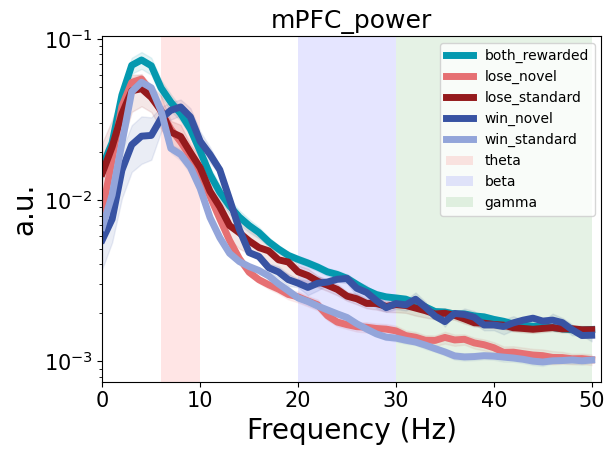

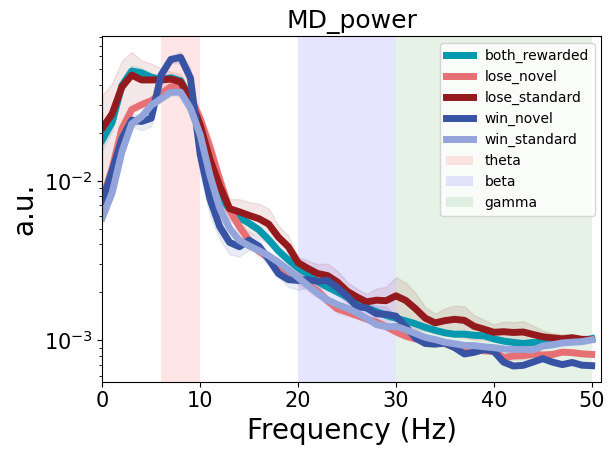

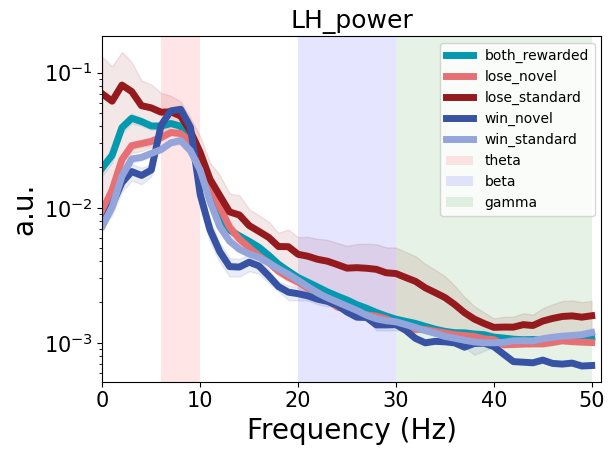

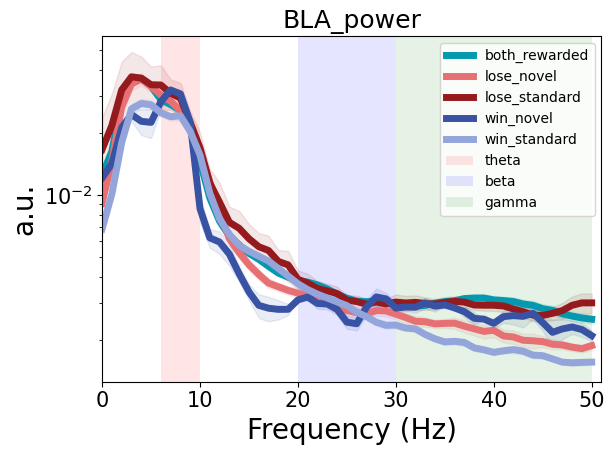

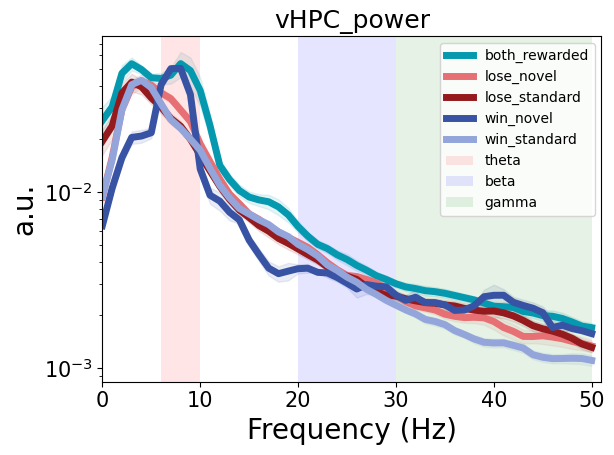

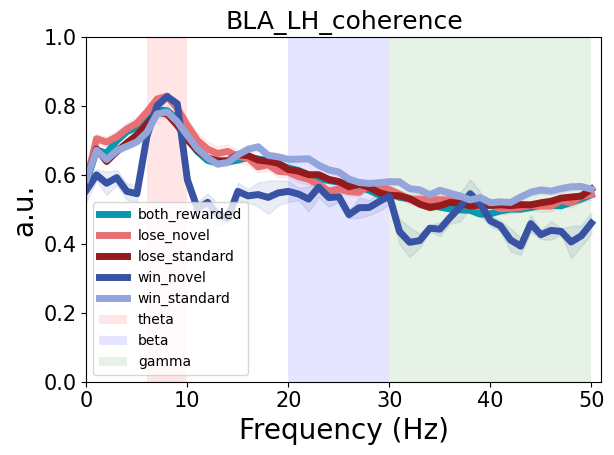

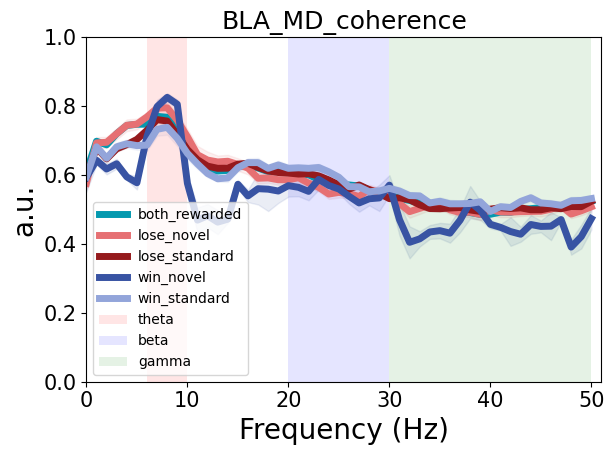

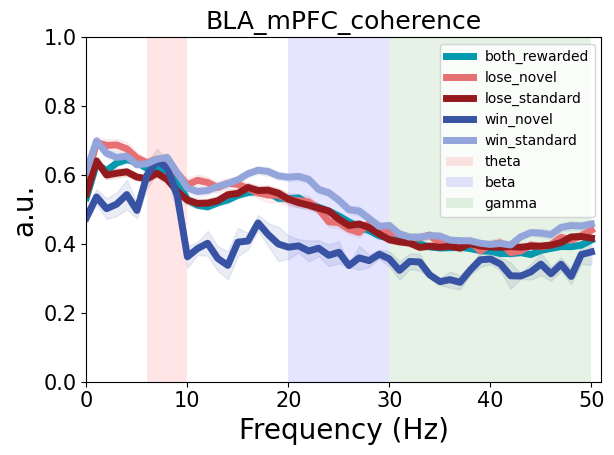

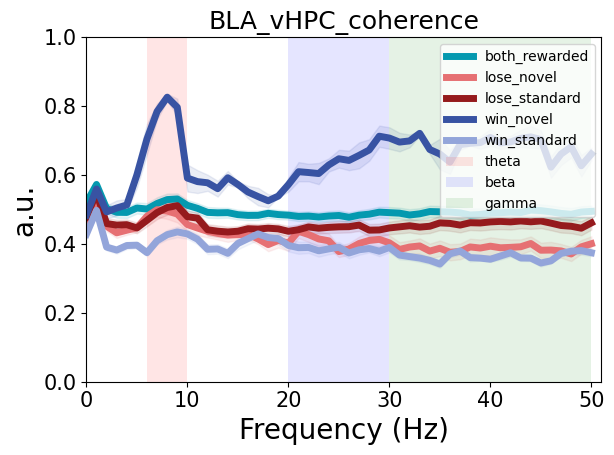

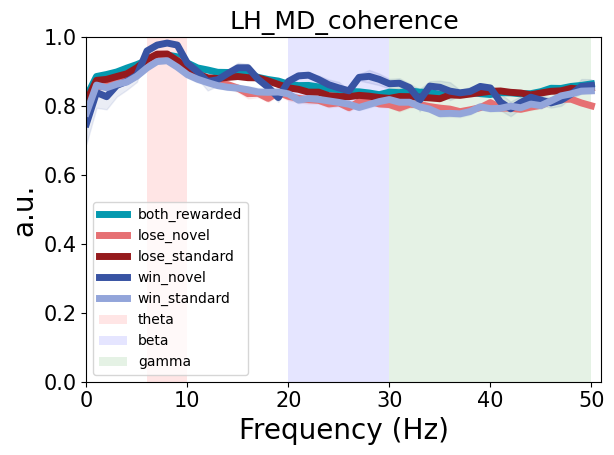

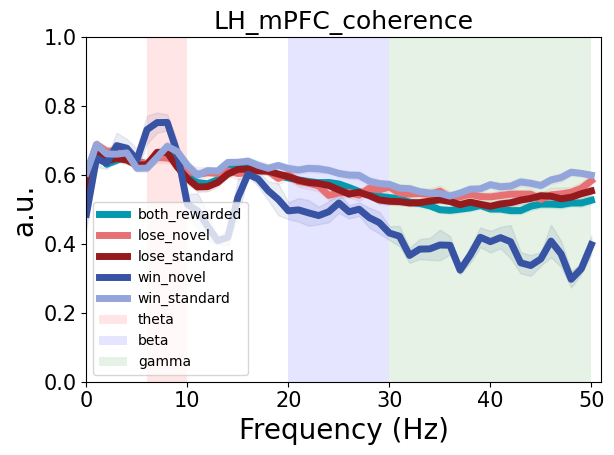

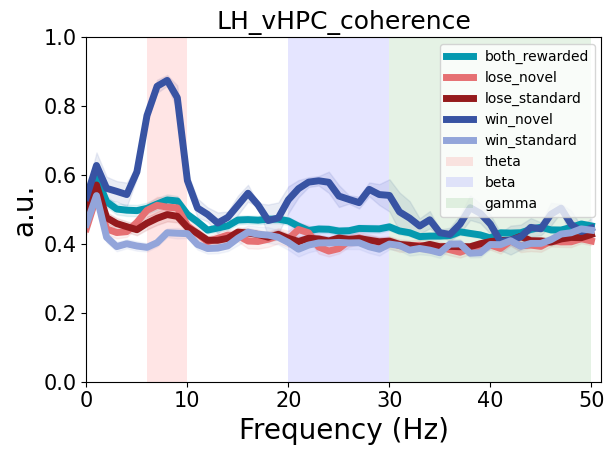

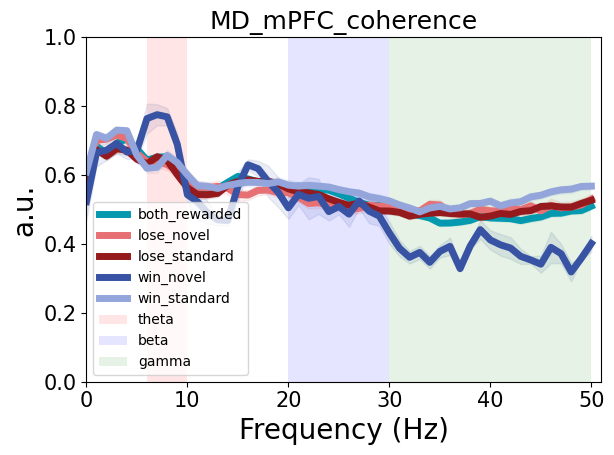

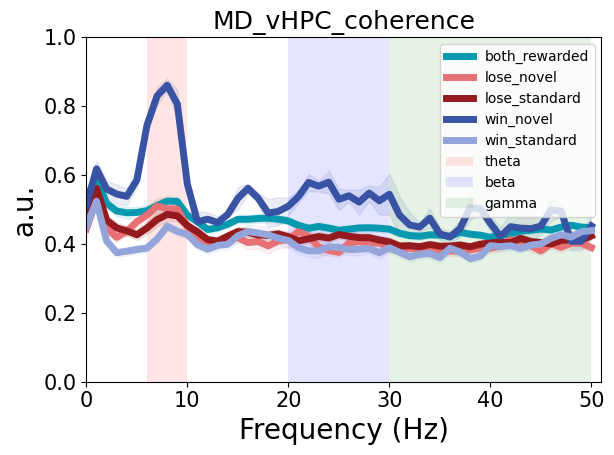

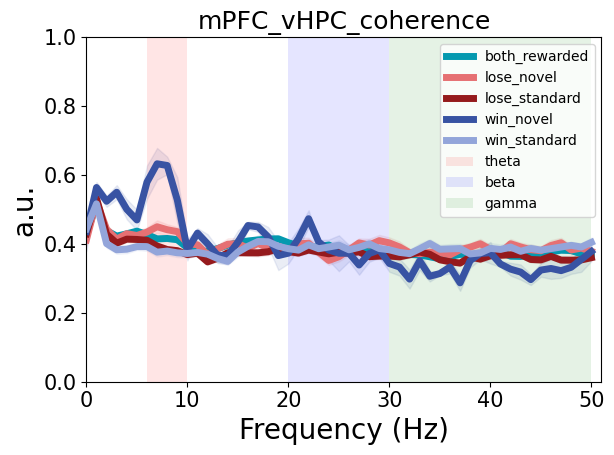

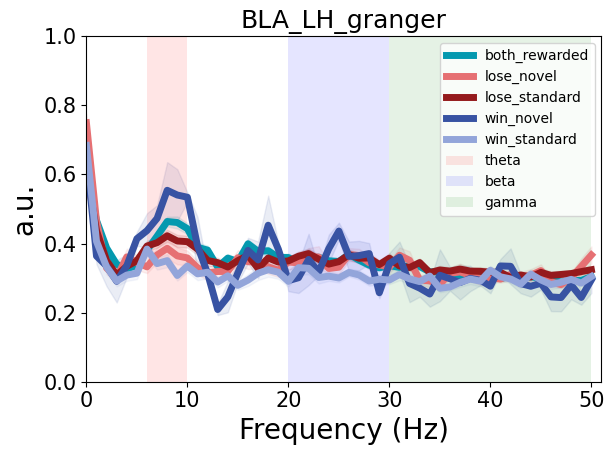

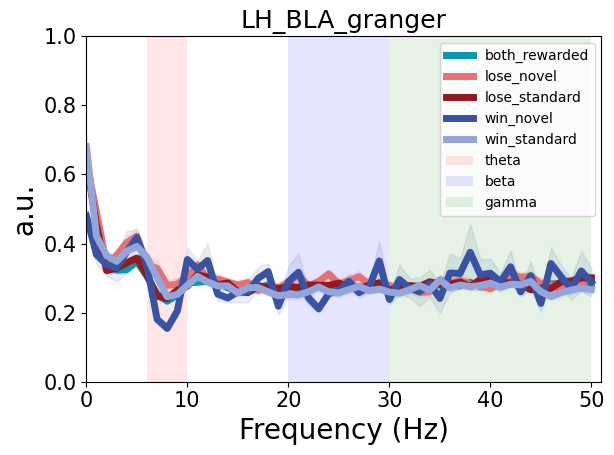

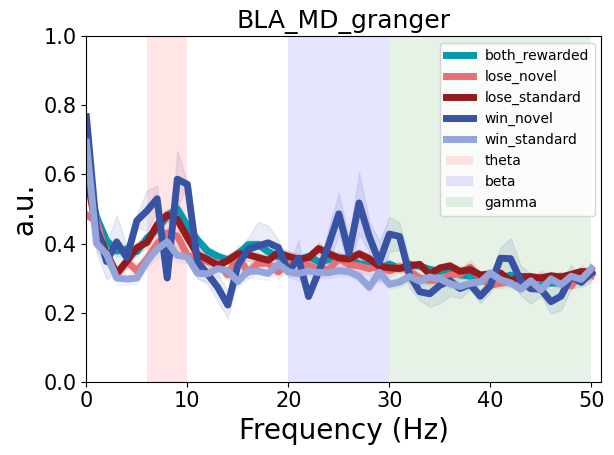

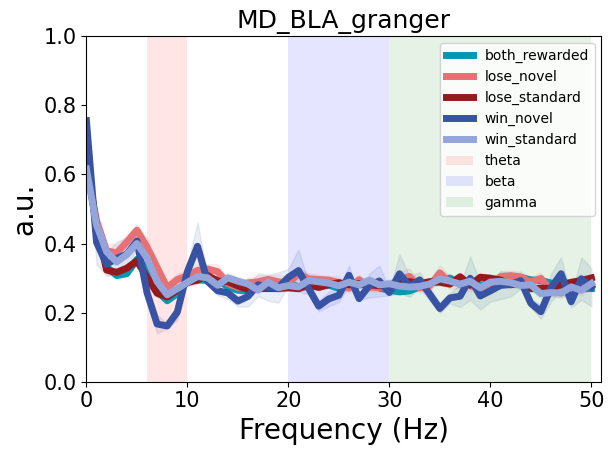

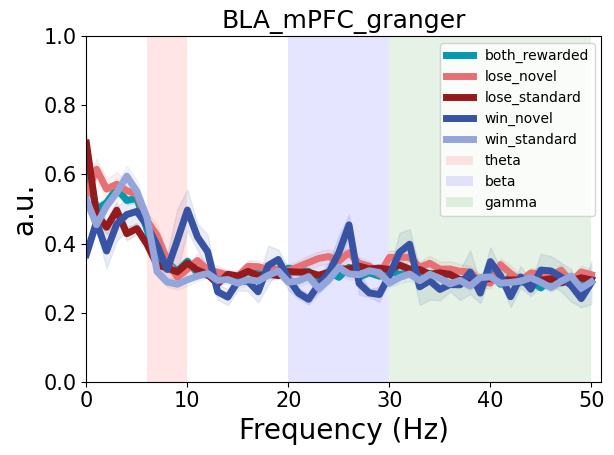

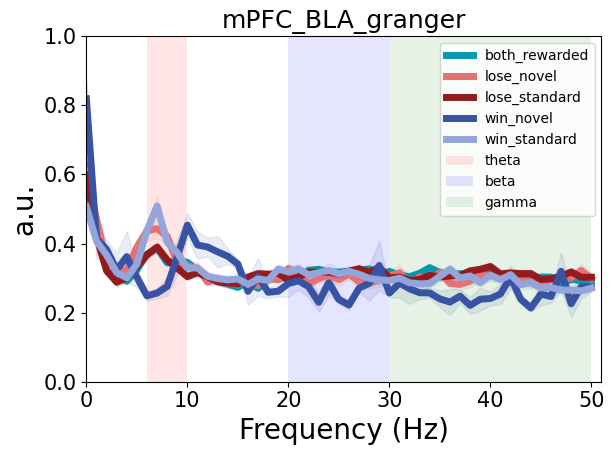

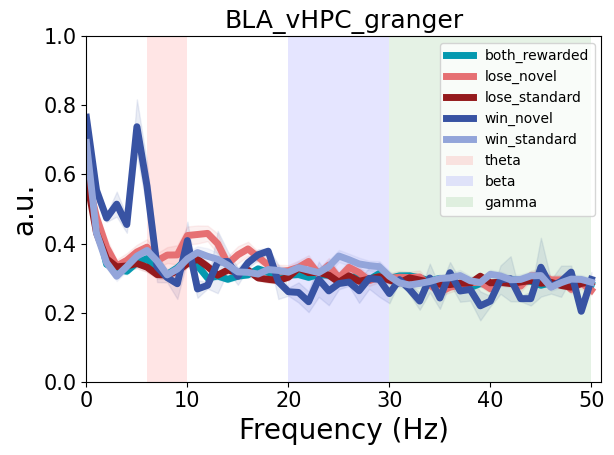

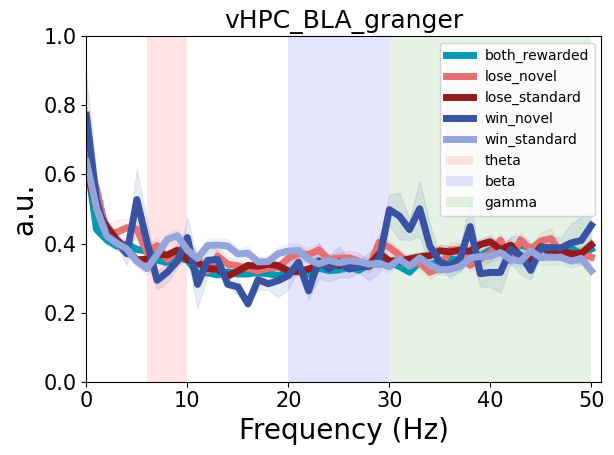

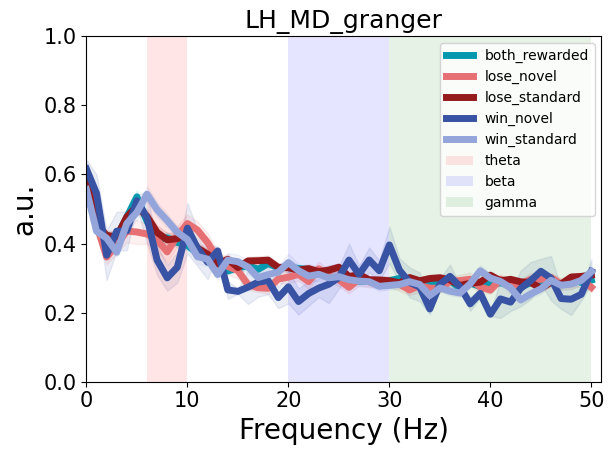

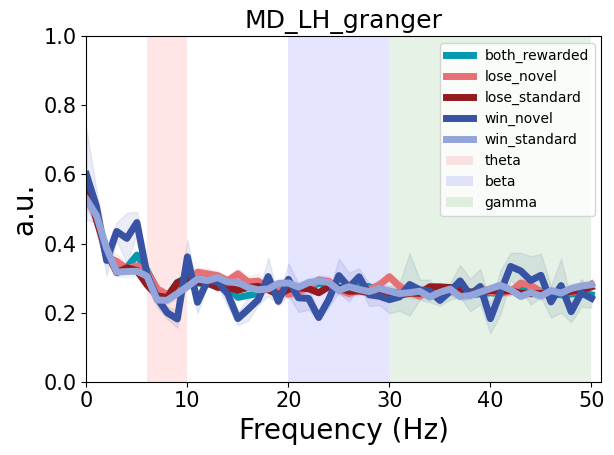

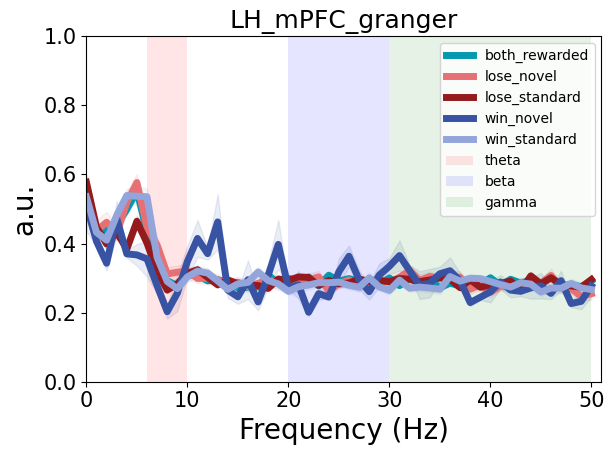

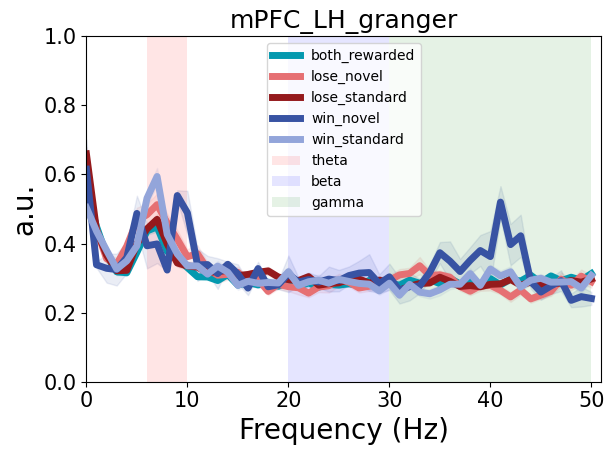

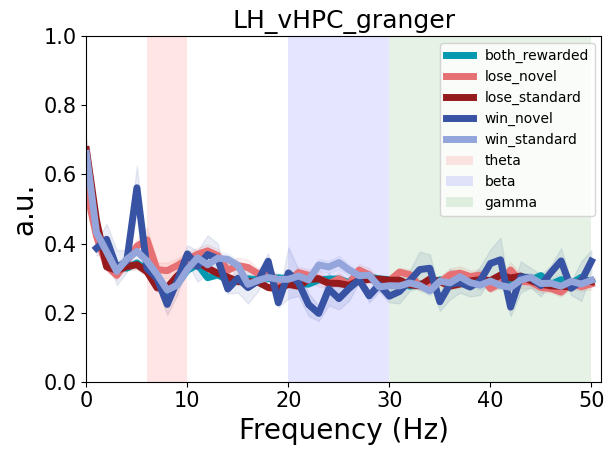

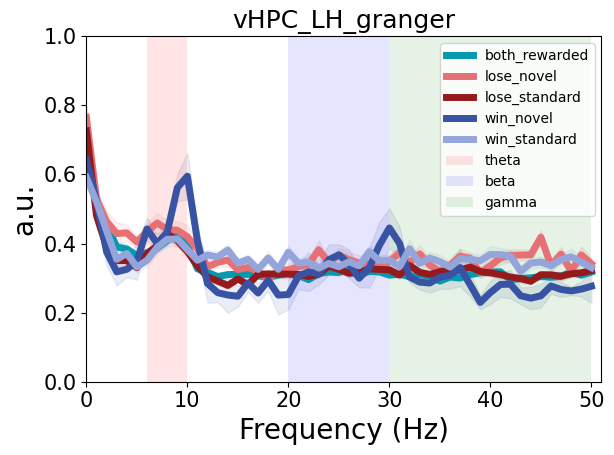

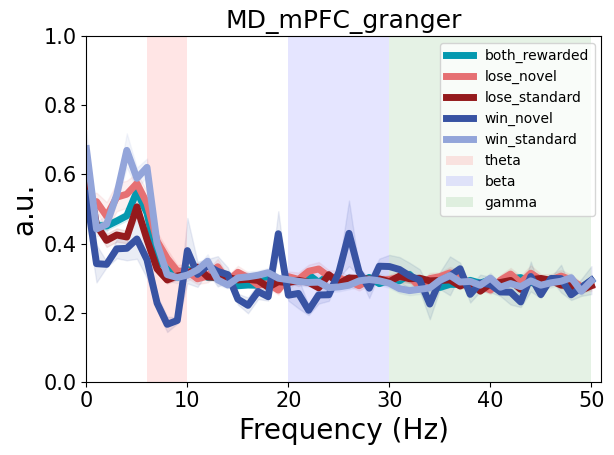

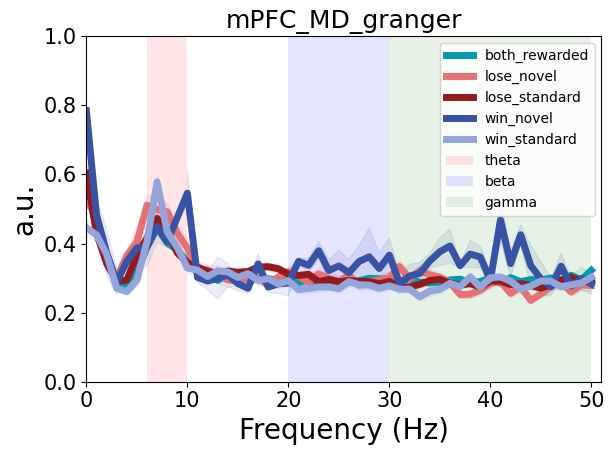

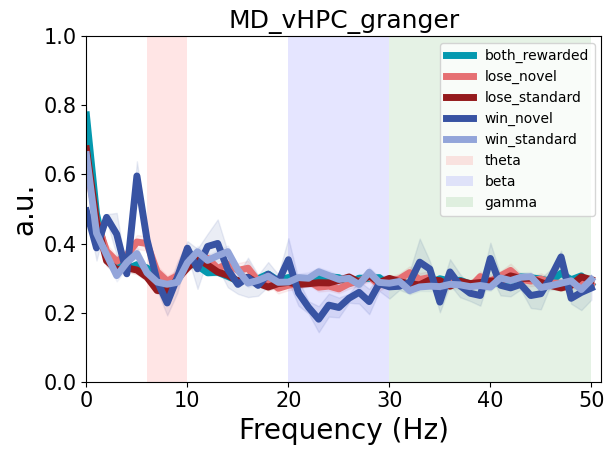

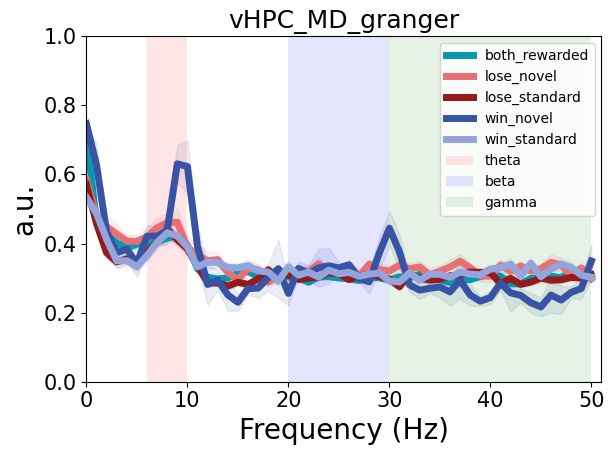

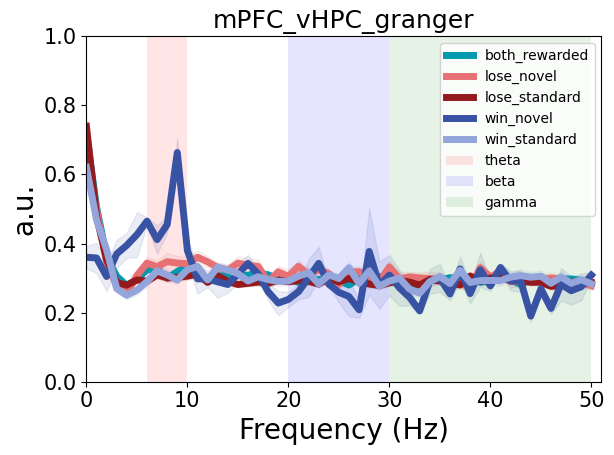

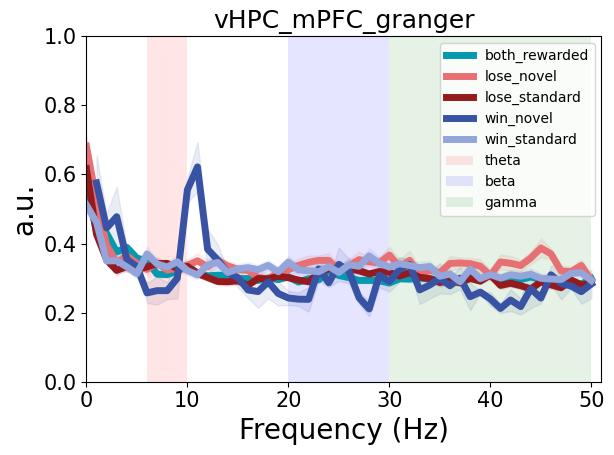

In [253]:
low_freq = 0
high_freq = 51

for col in data_columns:
    fig, ax = plt.subplots()
    current_frequencies = range(low_freq, high_freq)

    plt.title("{}".format(col.split("all")[0].strip("_")))
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("a.u.", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    if "power" in col:
        plt.yscale("log")
    else:
        plt.ylim(0, 1)
    
    for index, row in grouped_all_trials_df.iterrows():   
        mean_power = row["mean_{}".format(col)][low_freq: high_freq]
        sem_power = row["sem_{}".format(col)][low_freq: high_freq]
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(index), linewidth=5, color=OUTCOME_TO_COLOR[index])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[index])
        except:
            pass
        
    
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=10, ncol=1)
    # ax.get_legend().remove()
    # plt.show()
    plt.tight_layout()
    plt.savefig("./proc/plots/{}.png".format(col))
               

In [ ]:
    grouped_all_trials_df["mean_{}".format(col)] = grouped_all_trials_df[col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["sem_{}".format(col)] = grouped_all_trials_df[col].apply(lambda x: np.nanstd(np.vstack(x), axis=0) / np.sqrt(x.shape[0]))

    
    fig, ax = plt.subplots()
    plt.title("Power Spectra {} ".format(region.split("_")[0]), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Power (a.u.)", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    plt.yscale("log")
        
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row[GROUPINGS]), linewidth=5, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)

In [ ]:
for col in data_columns:
    break
    

In [186]:
FONTSIZE=20

In [187]:
font = {'weight' : 'medium',
        'size'   : 15}

matplotlib.rc('font', **font)

In [188]:
BAND_TO_FREQ

{'theta': (6, 11), 'beta': (20, 31), 'gamma': (30, 51)}

In [117]:
BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'beta': (20, 30), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'beta': "blue", 'gamma': "green"}

BAND_TO_FREQ_PLOT = {'theta': (6, 10), 'gamma': (30, 50)}
BAND_TO_FREQ_COLOR = {'theta': "red", 'gamma': "green"}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


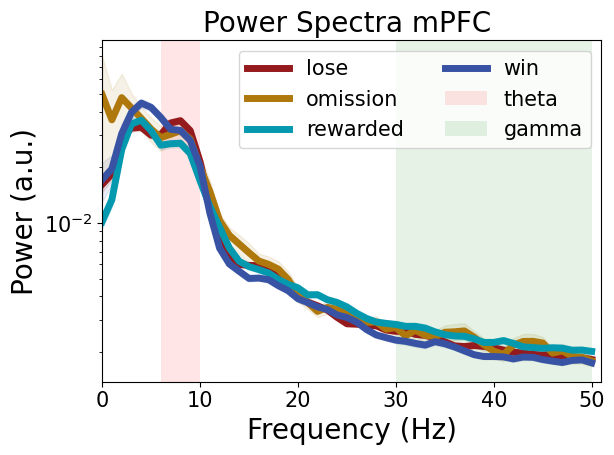

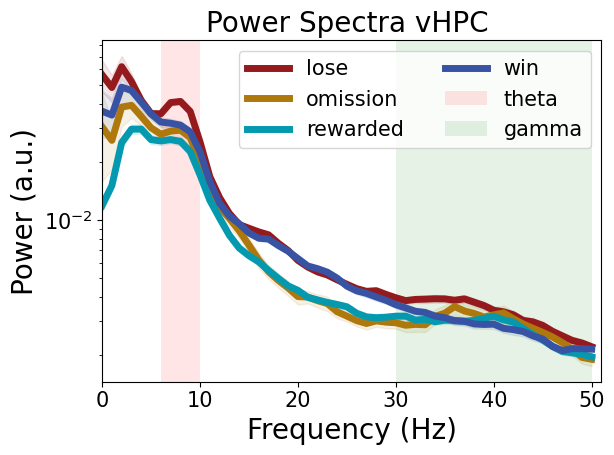

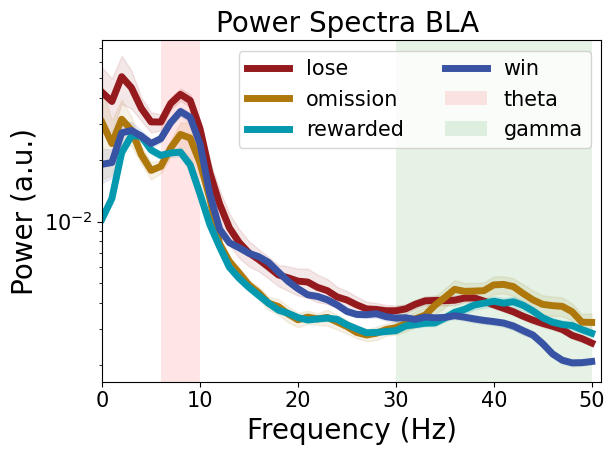

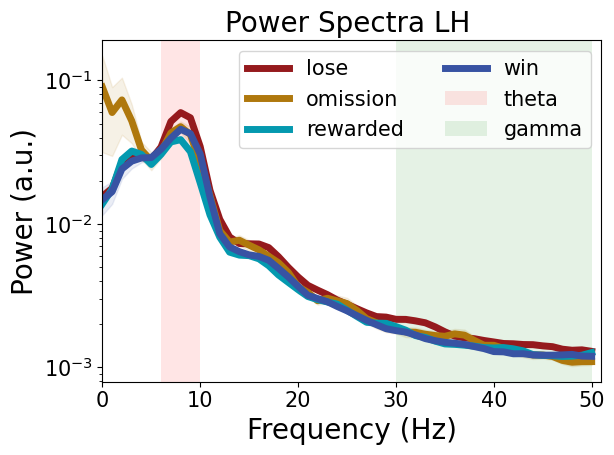

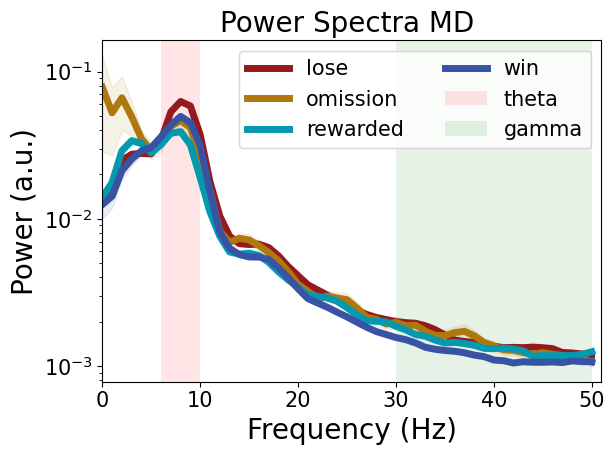

In [118]:
low_freq = 0
high_freq = 51
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[(grouped_all_trials_df["brain_region"] == region) & (grouped_all_trials_df["trial_or_baseline"] == "trial")]

    fig, ax = plt.subplots()
    plt.title("Power Spectra {} ".format(region.split("_")[0]), fontsize=FONTSIZE)
    plt.xlabel("Frequency (Hz)", fontsize=FONTSIZE)
    plt.ylabel("Power (a.u.)", fontsize=FONTSIZE)
    plt.xlim(low_freq, high_freq) 
    plt.yscale("log")
        
    for index, row in region_df.iterrows():           

        current_frequencies = ALL_FREQUENCIES[low_freq: high_freq]
        mean_power = row["mean_power"][low_freq: high_freq]
        sem_power = row["sem_power"][low_freq: high_freq]
            
        
        try:
            ax = sns.lineplot(x=current_frequencies, y=mean_power, \
            label="{}".format(row[GROUPINGS]), linewidth=5, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
            
            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.1, color=OUTCOME_TO_COLOR[row[GROUPINGS]])
        
        except Exception as e: 
            print(e)
            continue
    for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
        ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.1, label=band)
    plt.legend(fontsize=15, ncol=2)


    plt.tight_layout()
    plt.savefig("./proc/velocity_parsed_power/power_spectra_all_conditions/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.png".format(low_freq, high_freq, region.split("_")[0]))
    plt.savefig("./proc/velocity_parsed_power/power_spectra_all_conditions/rce_velocity_parsed_lfp_power_freq_{}_to_{}_region_{}.eps".format(low_freq, high_freq, region.split("_")[0]))

In [144]:
FINAL_LFP_TRACES_DF["recording"].unique()

array(['20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged',
       '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged',
       '20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-1_t1b2L_box1_merged',
       '20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged',
       '20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged',
       '20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4_t3b3L_box1_merged',
       '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged',
       '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged',
       '20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged',
       '20230629_111937_standard_comp_to_novel_agent_D2_subj_1-4vs1-1and2-2_merged',
       '20230630_115506_standard_comp_to_novel_agent_D3_subj_1-2vs1-4and2-2_merged'],
      dtype=object)

In [ ]:
raise ValueError()

In [ ]:
MERGED_LFP_TRACES_DF["]

In [54]:
raise ValueError()

ValueError: 